# Splines in PyMC3

- [Question on PyMC Discourse](https://discourse.pymc.io/t/spline-regression-in-pymc3/6235)
- [*Statistical Rethinking* example in PyMC3](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_04.ipynb)
- [*Statistical Rethinking* example in Stan](https://vincentarelbundock.github.io/rethinking2/04.html)

In [1]:
import string
import warnings
from pathlib import Path

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from patsy import dmatrix
from theano import tensor as tt

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")
rethinking_data_path = Path("../data/rethinking_data")
modeling_data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")

## Replicate the example from *Statistical Rethinking*

In [2]:
d = pd.read_csv(rethinking_data_path / "cherry_blossoms.csv")
# nans are not treated as in the book
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
year,1533.395,291.123,1016.00,1978.00
doy,104.921,6.258,92.00,115.00
temp,6.100,0.683,4.80,7.32
temp_upper,6.938,0.812,5.56,8.40
temp_lower,5.264,0.762,3.75,6.83


In [3]:
d2 = d.dropna(subset=["doy"]).reset_index(drop=True)
d2.head(n=10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


In [4]:
d2.shape

(827, 5)

In [5]:
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

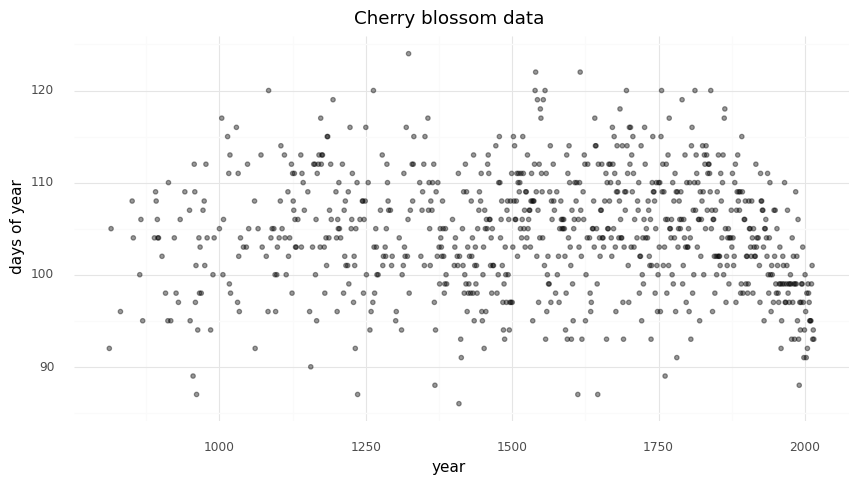

<ggplot: (8783701835561)>

In [6]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data")
)

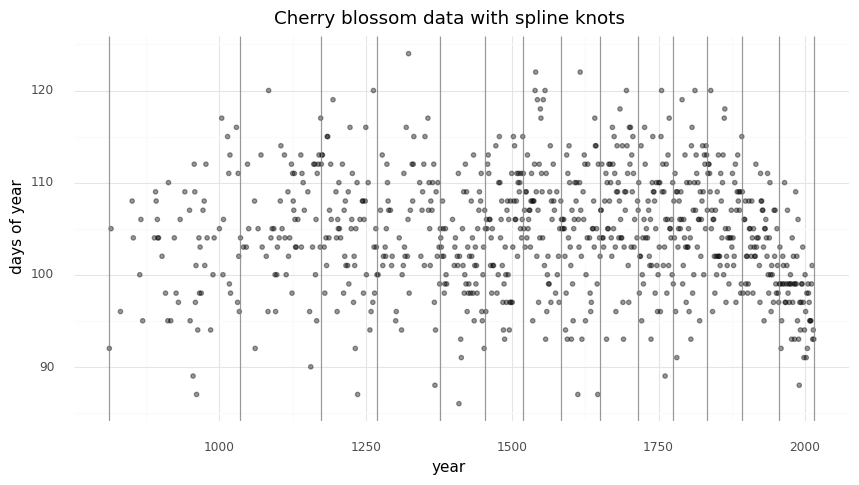

<ggplot: (8783702133465)>

In [7]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

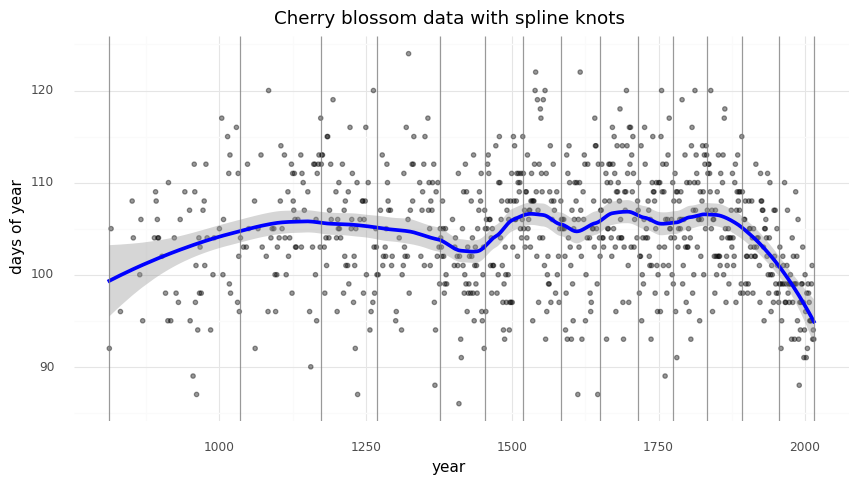

<ggplot: (8783702372545)>

In [8]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_smooth(method="loess", span=0.3, size=1.5, color="blue", linetype="-")
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

In [9]:
d2["knot_group"] = [np.where(a <= knot_list)[0][0] for a in d2.year]
d2["knot_group"] = pd.Categorical(d2["knot_group"], ordered=True)

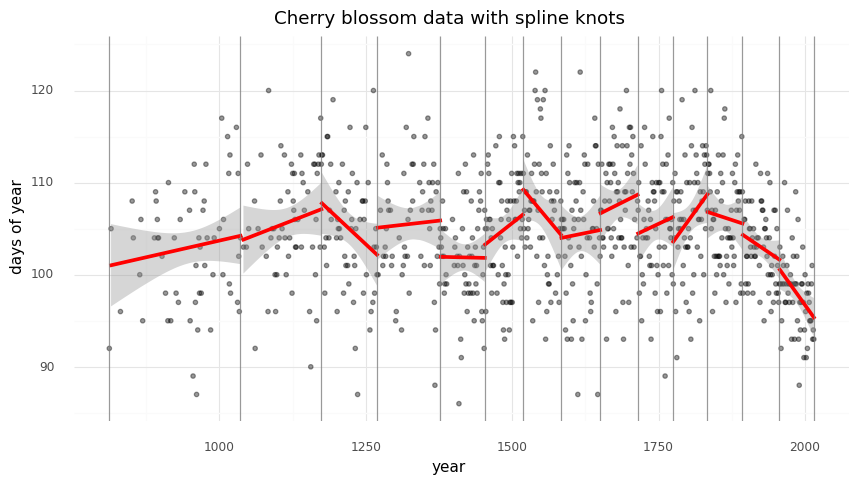

<ggplot: (8783703094129)>

In [10]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_smooth(
        gg.aes(group="knot_group"), method="lm", size=1.5, color="red", linetype="-"
    )
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

In [11]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

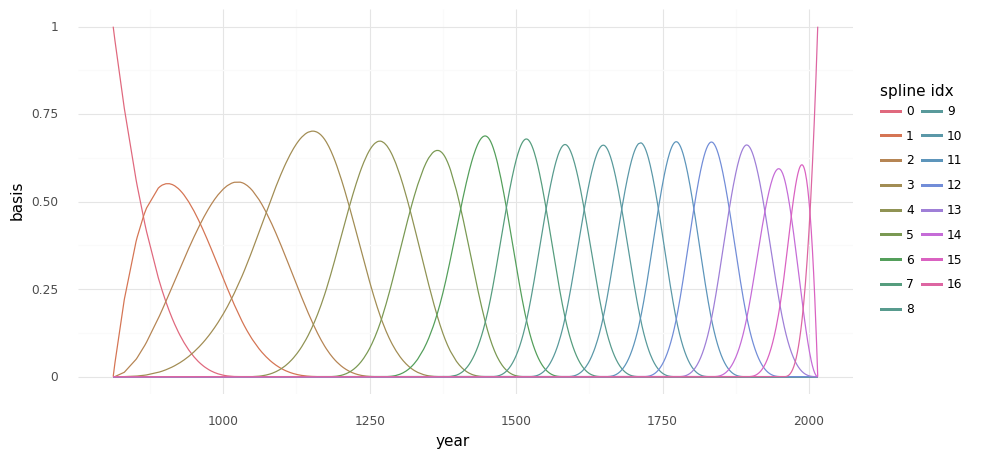

<ggplot: (8783703262025)>

In [12]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(spline_df, gg.aes(x="year", y="value"))
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"))
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2), color_space="husl")
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="basis", color="spline idx")
)

In [13]:
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)

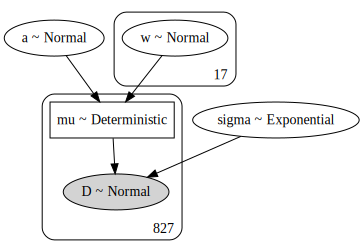

In [14]:
pm.model_to_graphviz(m4_7)

In [15]:
with m4_7:
    prior_pc = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace_m4_7 = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED)
    post_pc = pm.sample_posterior_predictive(trace_m4_7, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:30<00:00, 264.84draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 4000/4000 [00:05<00:00, 755.90it/s]


In [16]:
az_m4_7 = az.from_pymc3(
    model=m4_7, trace=trace_m4_7, posterior_predictive=post_pc, prior=prior_pc
)

In [17]:
az.summary(az_m4_7, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,103.303,2.424,98.879,107.724,0.098,0.069,615.0,614.0,618.0,1027.0,1.0
w[0],-2.876,3.862,-10.391,4.208,0.110,0.078,1225.0,1225.0,1223.0,2105.0,1.0
w[1],-0.920,3.944,-7.944,6.870,0.109,0.077,1303.0,1303.0,1306.0,1794.0,1.0
w[2],-0.950,3.640,-7.690,5.972,0.115,0.082,994.0,994.0,995.0,1799.0,1.0
w[3],4.896,2.917,-1.005,10.029,0.099,0.070,871.0,871.0,872.0,1236.0,1.0
w[4],-0.827,2.937,-6.642,4.437,0.105,0.075,776.0,776.0,781.0,1199.0,1.0
w[5],4.384,2.969,-0.994,10.089,0.098,0.069,921.0,921.0,922.0,1600.0,1.0
w[6],-5.305,2.848,-10.728,-0.249,0.103,0.073,771.0,771.0,774.0,1226.0,1.0
w[7],7.899,2.845,2.319,12.968,0.098,0.070,848.0,818.0,849.0,1546.0,1.0
w[8],-0.974,2.921,-6.470,4.431,0.100,0.070,861.0,861.0,863.0,1402.0,1.0


In [18]:
print(az.summary(az_m4_7, var_names=["a", "w", "sigma"]).to_markdown())

|       |    mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_mean |   ess_sd |   ess_bulk |   ess_tail |   r_hat |
|:------|--------:|------:|---------:|----------:|------------:|----------:|-----------:|---------:|-----------:|-----------:|--------:|
| a     | 103.303 | 2.424 |   98.879 |   107.724 |       0.098 |     0.069 |        615 |      614 |        618 |       1027 |       1 |
| w[0]  |  -2.876 | 3.862 |  -10.391 |     4.208 |       0.11  |     0.078 |       1225 |     1225 |       1223 |       2105 |       1 |
| w[1]  |  -0.92  | 3.944 |   -7.944 |     6.87  |       0.109 |     0.077 |       1303 |     1303 |       1306 |       1794 |       1 |
| w[2]  |  -0.95  | 3.64  |   -7.69  |     5.972 |       0.115 |     0.082 |        994 |      994 |        995 |       1799 |       1 |
| w[3]  |   4.896 | 2.917 |   -1.005 |    10.029 |       0.099 |     0.07  |        871 |      871 |        872 |       1236 |       1 |
| w[4]  |  -0.827 | 2.937 |   -6.642 |   

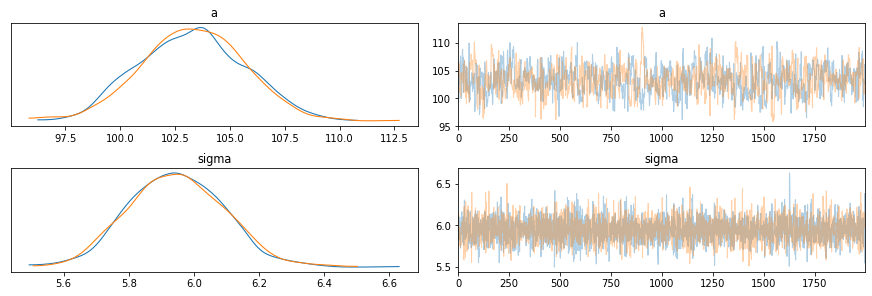

In [19]:
az.plot_trace(az_m4_7, var_names=["a", "sigma"])
plt.show()

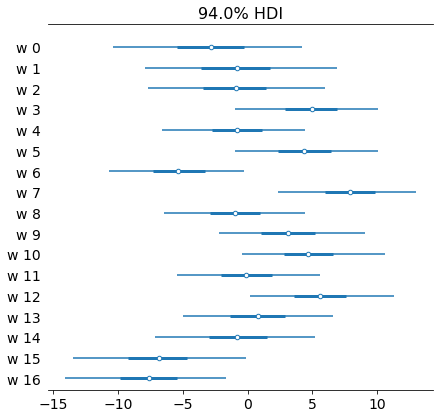

In [20]:
az.plot_forest(az_m4_7, var_names=["w"], combined=True)
plt.show()

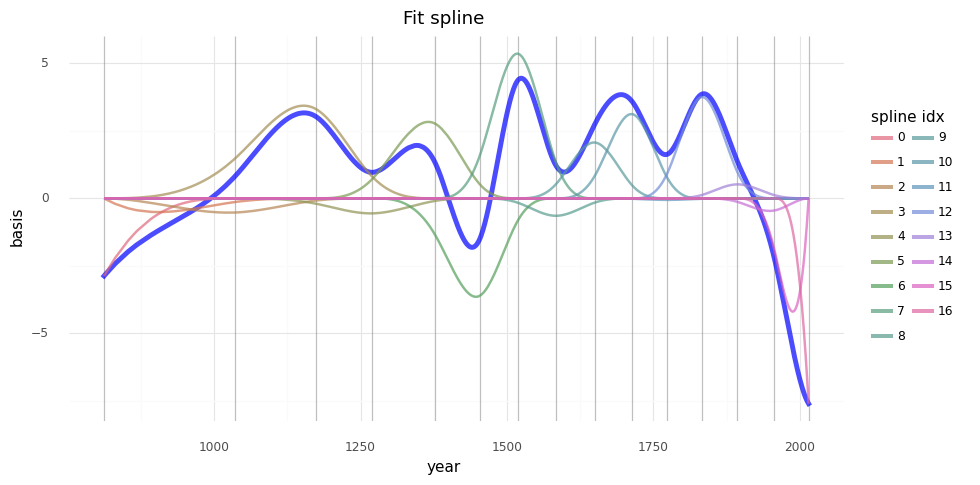

<ggplot: (8783680126061)>

In [22]:
wp = trace_m4_7["w"].mean(0)

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(spline_df, gg.aes(x="year", y="value"))
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.5)
    + gg.geom_line(data=spline_df_merged, linetype="-", color="blue", size=2, alpha=0.7)
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"), alpha=0.7, size=1)
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2), color_space="husl")
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="basis", title="Fit spline", color="spline idx")
)

In [23]:
post_pred = az.summary(az_m4_7, var_names=["mu"]).reset_index(drop=True)
d2_post = d2.copy().reset_index(drop=True)
d2_post["pred_mean"] = post_pred["mean"]
d2_post["pred_hdi_lower"] = post_pred["hdi_3%"]
d2_post["pred_hdi_upper"] = post_pred["hdi_97%"]

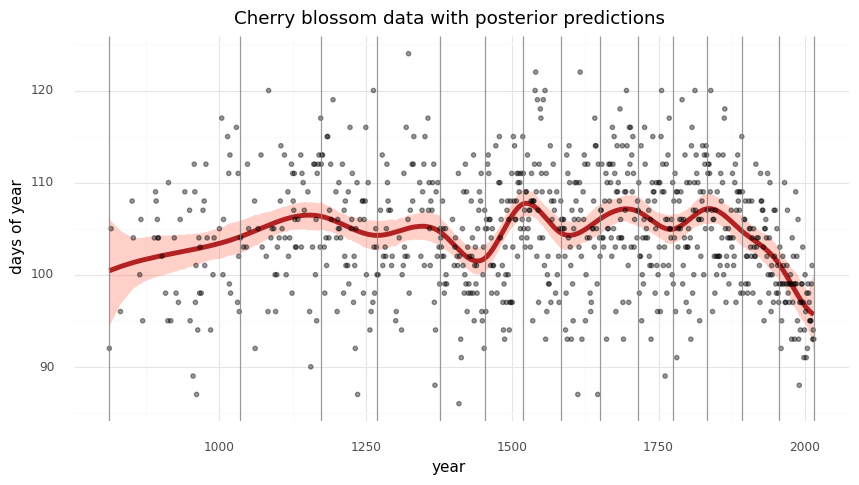

<ggplot: (8783680300445)>

In [24]:
(
    gg.ggplot(d2_post, gg.aes(x="year"))
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.geom_point(gg.aes(y="doy"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(
        x="year",
        y="days of year",
        title="Cherry blossom data with posterior predictions",
    )
)

## Example with CNA data

In [14]:
modeling_data = pd.read_csv(modeling_data_path)
modeling_data

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,AAGAGGCCGGTCAAATTCAG,42-mg-ba-311cas9_repa_p6_batch3,-0.405499,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.845287,1.328646,0,False,NaN,NaN,NaN,NaN,False,1.263034
1,AATCAACCCACAGCTGCACA,42-mg-ba-311cas9_repa_p6_batch3,-0.133541,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.827398,1.287359,2,False,missense_mutation;missense_mutation,FALSE;FALSE,TRUE;TRUE,TRUE;TRUE,False,5.220330
2,AATTACTACTTGCTTCCTGT,42-mg-ba-311cas9_repa_p6_batch3,-0.491495,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.879280,1.409165,0,False,NaN,NaN,NaN,NaN,False,3.008989
3,ACCTGTATGACGAAACCGTG,42-mg-ba-311cas9_repa_p6_batch3,-0.015850,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
4,ACTCTGTTCCTTCATCTCCG,42-mg-ba-311cas9_repa_p6_batch3,-0.530277,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.990378,1.692253,0,False,NaN,NaN,NaN,NaN,False,5.822730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60044,TTATTAATGTAGCCTCACGG,ykg1-311cas9_repb_p6_batch3,-0.096160,3,True,ACH-000570,Primary,central_nervous_system,glioma,WT,...,1.129110,2.092901,1,False,missense_mutation,FALSE,TRUE,TRUE,False,3.792855
60045,TTCCGTTTATCATGAAGCCG,ykg1-311cas9_repb_p6_batch3,-0.975325,3,True,ACH-000570,Primary,central_nervous_system,glioma,WT,...,1.129110,2.092901,0,False,NaN,NaN,NaN,NaN,False,6.134426
60046,TTGCAATGTGATGGAAGGGG,ykg1-311cas9_repb_p6_batch3,0.408497,3,True,ACH-000570,Primary,central_nervous_system,glioma,WT,...,0.950623,1.587322,0,False,NaN,NaN,NaN,NaN,False,3.645010
60047,TTGTCCCAGCCGTCAAACCG,ykg1-311cas9_repb_p6_batch3,-0.050832,3,True,ACH-000570,Primary,central_nervous_system,glioma,WT,...,1.071891,1.920898,0,False,NaN,NaN,NaN,NaN,False,0.992768


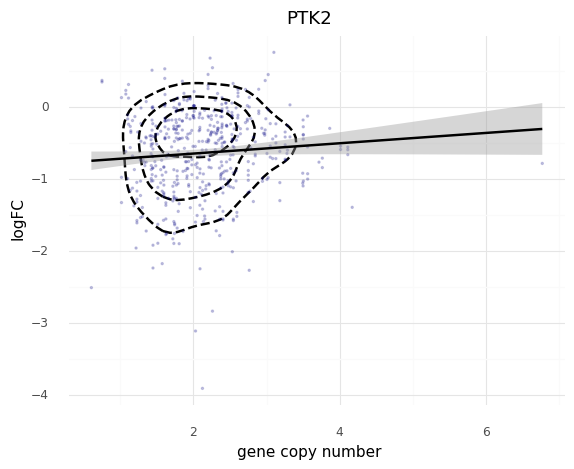

<ggplot: (8789285110896)>

In [15]:
np.random.seed(RANDOM_SEED)
ptk2_data = modeling_data[modeling_data.hugo_symbol == "PTK2"]
ptk2_data = ptk2_data.sample(n=500)


(
    gg.ggplot(ptk2_data, gg.aes(x="gene_cn", y="lfc"))
    + gg.geom_density_2d(color="black", alpha=1, size=1, linetype="--")
    + gg.geom_point(size=0.4, alpha=0.2, color="navy")
    + gg.geom_smooth(method="lm")
    + gg.labs(x="gene copy number", y="logFC", title="PTK2")
)

In [16]:
ptk2_data.shape[0]

500

In [17]:
cn_num_knots = 5
cn_knot_list = np.quantile(ptk2_data.gene_cn, np.linspace(0, 1, cn_num_knots))


ptk2_B = dmatrix(
    "bs(x, knots=knots, degree=3, include_intercept=True) - 1",
    {"x": ptk2_data.gene_cn, "knots": cn_knot_list[1:-1]},
)

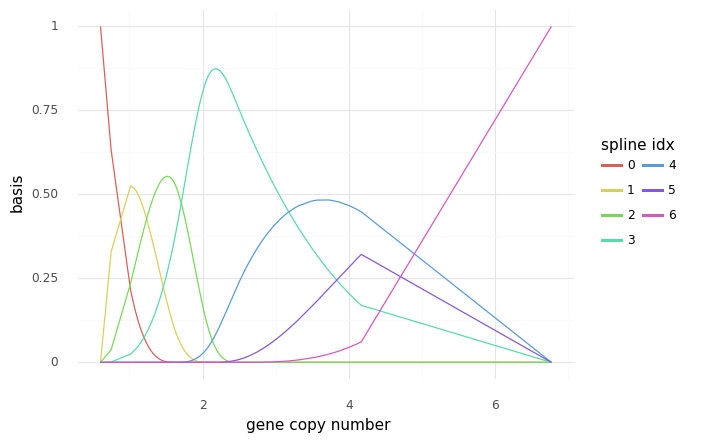

<ggplot: (8789285083263)>

In [18]:
ptk2_spline_df = (
    pd.DataFrame(ptk2_B)
    .assign(gene_cn=ptk2_data.gene_cn.values)
    .melt("gene_cn", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(ptk2_spline_df, gg.aes(x="gene_cn", y="value"))
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"))
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2))
    + gg.labs(x="gene copy number", y="basis", color="spline idx")
)

In [19]:
with pm.Model() as m_ptk2:
    a = pm.Normal("a", 100, 10)
    w = pm.Normal("w", mu=0, sd=10, shape=ptk2_B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(ptk2_B, order="F"), w.T))
    # mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=ptk2_data.lfc)

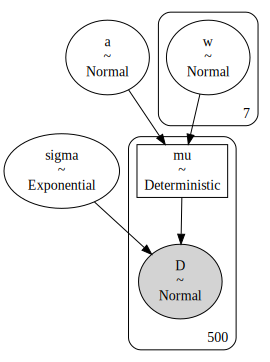

In [20]:
pm.model_to_graphviz(m_ptk2)

In [21]:
with m_ptk2:
    prior_pc = pm.sample_prior_predictive()
    trace_m_ptk2 = pm.sample(1000)
    post_pc = pm.sample_posterior_predictive(trace_m_ptk2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 69 seconds.
The acceptance probability does not match the target. It is 0.9010949039327413, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [22]:
az_ptk2 = az.from_pymc3(
    model=m_ptk2, trace=trace_m_ptk2, posterior_predictive=post_pc, prior=prior_pc
)

In [23]:
post_pred = az.summary(az_ptk2, var_names=["mu"]).reset_index(drop=True)
ptk2_post = ptk2_data.copy().reset_index(drop=True)
ptk2_post["pred_mean"] = post_pred["mean"]
ptk2_post["pred_hdi_lower"] = post_pred["hdi_3%"]
ptk2_post["pred_hdi_upper"] = post_pred["hdi_97%"]
ptk2_post.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,pred_mean,pred_hdi_lower,pred_hdi_upper
0,GGAGGTTCACTGGCTTCACG,nci-h2023-311cas9 rep b p6_batch3,-0.886039,3,True,ACH-000781,Metastasis,lung,NSCLC,WT,...,False,NaN,NaN,NaN,NaN,False,6.183089,-0.557,-0.634,-0.477
1,GGAGGTTCACTGGCTTCACG,8-mg-ba-311cas9_repa_p5_batch3,0.030300,3,True,ACH-000137,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,6.864558,-0.545,-0.678,-0.422
2,ATATGGCTGACCTAATAGAT,r262-311cas9_repa_p6_batch2,-1.892173,2,True,ACH-001173,NaN,central_nervous_system,medulloblastoma,WT,...,False,NaN,NaN,NaN,NaN,False,4.636335,-0.724,-0.820,-0.624
3,GCGAGGTTCCATTCACCAGC,dkmg-311cas9_repb_p5_batch3,-0.306644,3,True,ACH-000244,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,6.314334,-0.728,-0.809,-0.632
4,GCGAGGTTCCATTCACCAGC,nci-h838-311cas9_repb_p4_batch3,-0.851729,3,True,ACH-000416,Metastasis,lung,NSCLC,WT,...,False,NaN,NaN,NaN,NaN,False,5.794936,-0.549,-0.632,-0.469


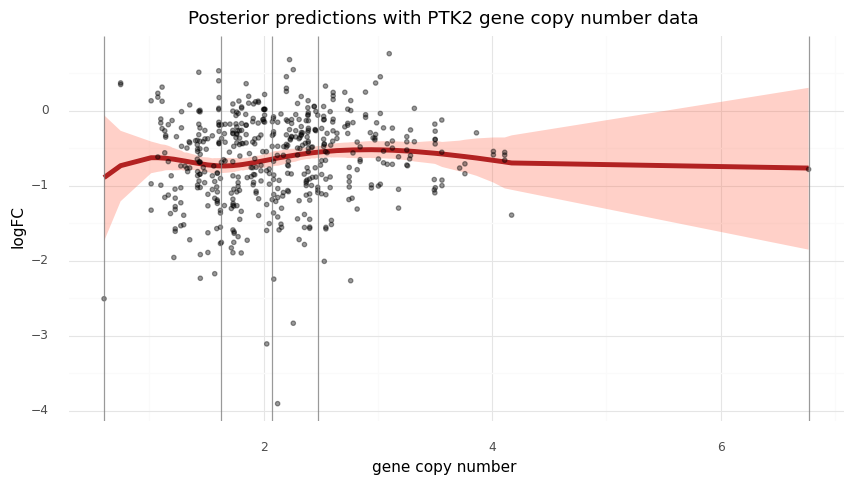

<ggplot: (8789284853068)>

In [24]:
(
    gg.ggplot(ptk2_post, gg.aes(x="gene_cn"))
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.geom_point(gg.aes(y="lfc"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=cn_knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(
        x="gene copy number",
        y="logFC",
        title="Posterior predictions with PTK2 gene copy number data",
    )
)

In [25]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

plotnine 0.7.1
pandas   1.1.3
arviz    0.10.0
pymc3    3.9.3
numpy    1.19.2
seaborn  0.11.0
last updated: 2020-11-13 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit
host name  : compute-e-16-229.o2.rc.hms.harvard.edu
Git branch : subset-data
